# InfoGAN

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

import torch.autograd as autograd
from torch.utils.data import DataLoader
import torchvision.datasets as dset
import torchvision.transforms as transforms

from torchvision.utils import save_image
from torchvision.utils import make_grid

import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
#Visualization Tool requires "pip install visdom" (https://github.com/facebookresearch/visdom)
# from visdom_utils import VisFunc
# vf = VisFunc(enval='infoGAN') # Visdom

## MNIST Dataset

In [3]:
batch_size = 100
dataset = dset.MNIST('./dataset', transform=transforms.ToTensor(), download=True)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4, drop_last=True)

## Define Model

In [4]:
# Feather Extractor
class FrontEnd(nn.Module):
    def __init__(self):
        super(FrontEnd, self).__init__()

        self.main = nn.Sequential(
            nn.Conv2d(1,64,4,2,1),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Conv2d(64,128,4,2,1,bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Conv2d(128, 1024,7,bias=False),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.1, inplace=True),
        )

    def forward(self,x):
        output = self.main(x)
        return output

In [5]:
# Discriminator
class Dmodel(nn.Module):
    def __init__(self):
        super(Dmodel, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(1024,1,1),
            nn.Sigmoid()
        )

    def forward(self,x):
        output=self.main(x).view(-1,1)
        return output

In [6]:
# Classifier Q
class Qmodel(nn.Module):
    def __init__(self):
        super(Qmodel,self).__init__()

        self.conv = nn.Conv2d(1024,128,1,bias=False)
        self.bn = nn.BatchNorm2d(128)
        self.lReLU = nn.LeakyReLU(0.1, inplace=True)
        self.conv_disc = nn.Conv2d(128,10,1)
        self.conv_mu = nn.Conv2d(128,2,1)
        self.conv_var = nn.Conv2d(128,2,1)

    def forward(self,x):
        y = self.conv(x)
        disc_logits = self.conv_disc(y).squeeze()
        mu = self.conv_mu(y).squeeze()
        var = self.conv_var(y).squeeze().exp()
        return disc_logits, mu, var

In [7]:
# Generator
class Gmodel(nn.Module):
    def __init__(self):
        super(Gmodel, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(74, 1024,1,1, bias=False),
            nn.BatchNorm2d(1024),
            nn.ReLU(True),
            nn.ConvTranspose2d(1024, 128,7,1,bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128,64,4,2,1,bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64,1,4,2,1,bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        output = self.main(x)
        return output


In [8]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)
    
# Models
FE=FrontEnd()
D=Dmodel()
Q=Qmodel()
G=Gmodel()

for i in [FE, D, Q, G]:
    i.cuda()
    i.apply(weights_init)

## Defin Losses & Optimizer

![log_gaussian](https://user-images.githubusercontent.com/613623/30778123-7328abc0-a0cd-11e7-8998-7e4ef07cc25f.png)
https://user-images.githubusercontent.com/613623/30778123-7328abc0-a0cd-11e7-8998-7e4ef07cc25f.png

In [9]:
# Define Losses
class log_gaussian:
    def __call__(self, x, mu, var):
        logli = -0.5*(var.mul(2*np.pi)+1e-6).log() - (x-mu).pow(2).div(var.mul(2.0)+1e-6)
        return logli.sum(1).mean().mul(-1)

criterionD = nn.BCELoss()
criterionQ_dis = nn.CrossEntropyLoss()
criterionQ_con = log_gaussian()

In [10]:
# Optimizers
optimD = optim.Adam([{'params':FE.parameters()},
                     {'params':D.parameters()}],
                    lr=0.0002, betas=(0.5, 0.99))

optimG = optim.Adam([{'params':G.parameters()},
                     {'params':Q.parameters()}],
                    lr=0.001, betas=(0.5, 0.99))

## Define Inputs Codes

In [11]:
# fixed random variables for test
c0 = torch.linspace(-1,1,10).repeat(10).view(-1,1)
c1 = torch.cat((c0, torch.zeros(1).expand_as(c0)),1).cuda()
c2 = torch.cat((torch.zeros(1).expand_as(c0), c0),1).cuda()
one_hot = torch.eye(10).repeat(1,1,10).view(batch_size,10).cuda()
fix_noise = torch.Tensor(batch_size, 62).uniform_(-1, 1).cuda()


# random noises sampling function
def _noise_sample(dis_c, con_c, noise, bs):
    idx = np.random.randint(10, size=bs)
    c = np.zeros((bs, 10))
    c[range(bs),idx] = 1.0
    dis_c.data.copy_(torch.Tensor(c))
    con_c.data.uniform_(-1.0, 1.0)
    noise.data.uniform_(-1.0, 1.0)
    z = torch.cat([noise, dis_c, con_c], 1).view(-1, 74, 1, 1)
    return z, idx

## Training

Epoch:0, Iter:0, Dloss: 1.4334299564361572, Gloss: 3.3204452991485596, Preal: 0.4593649208545685, Pfake: 0.4563789367675781


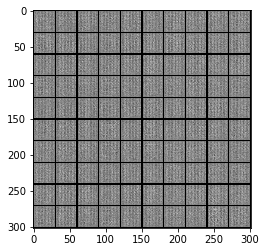

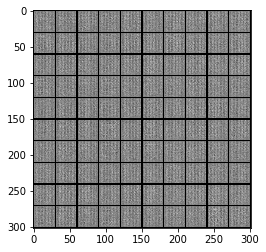

Epoch:0, Iter:200, Dloss: 0.716869056224823, Gloss: 1.31003999710083, Preal: 0.7358226776123047, Pfake: 0.2920904755592346


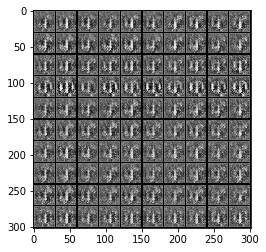

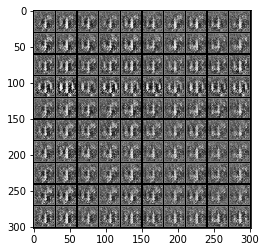

Epoch:0, Iter:400, Dloss: 1.164217233657837, Gloss: 0.9795026779174805, Preal: 0.5649694800376892, Pfake: 0.3913092017173767


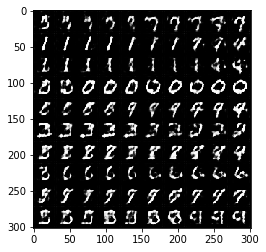

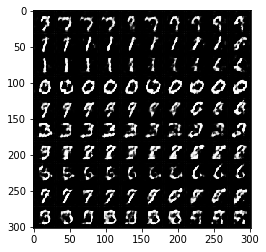

Epoch:1, Iter:0, Dloss: 1.0738682746887207, Gloss: 1.0232042074203491, Preal: 0.6059794425964355, Pfake: 0.37322288751602173


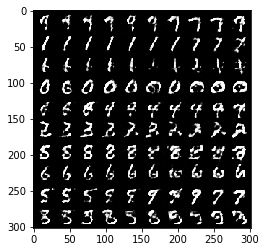

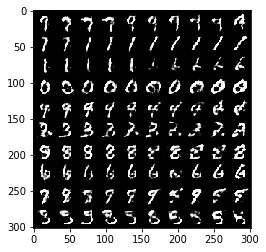

Epoch:1, Iter:200, Dloss: 1.1444330215454102, Gloss: 0.9037526845932007, Preal: 0.6028950214385986, Pfake: 0.39510488510131836


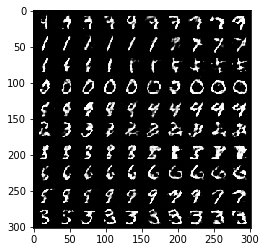

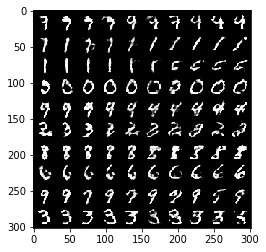

Epoch:1, Iter:400, Dloss: 1.1403493881225586, Gloss: 0.9623375535011292, Preal: 0.5696903467178345, Pfake: 0.38391566276550293


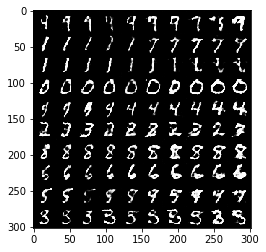

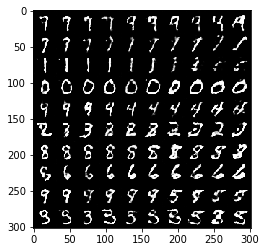

Epoch:2, Iter:0, Dloss: 1.140611171722412, Gloss: 0.963468074798584, Preal: 0.5847766995429993, Pfake: 0.3859799802303314


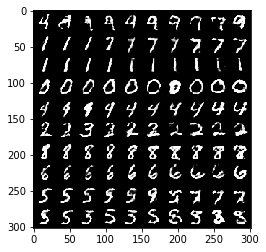

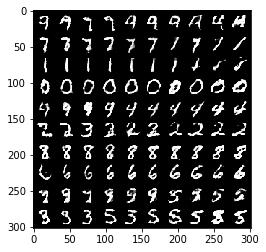

Epoch:2, Iter:200, Dloss: 1.2081778049468994, Gloss: 1.009941577911377, Preal: 0.569175660610199, Pfake: 0.4035429358482361


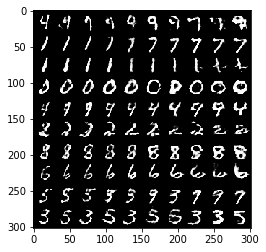

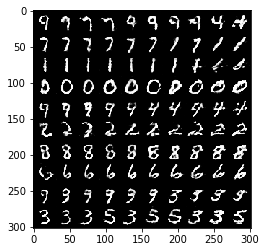

Epoch:2, Iter:400, Dloss: 1.2668644189834595, Gloss: 0.8454943895339966, Preal: 0.5711581707000732, Pfake: 0.4183262586593628


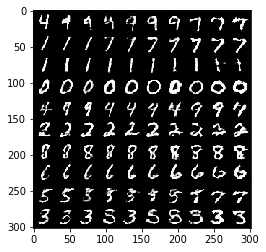

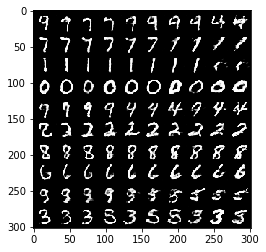

Epoch:3, Iter:0, Dloss: 1.2451704740524292, Gloss: 0.8590261936187744, Preal: 0.5608497262001038, Pfake: 0.41316893696784973


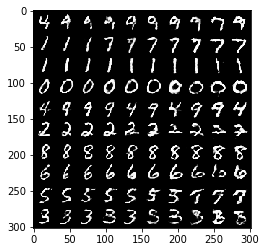

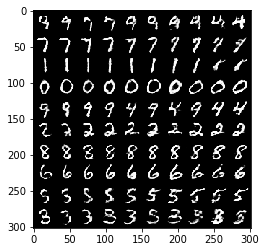

Epoch:3, Iter:200, Dloss: 1.1779049634933472, Gloss: 0.9756498336791992, Preal: 0.5766860246658325, Pfake: 0.39010924100875854


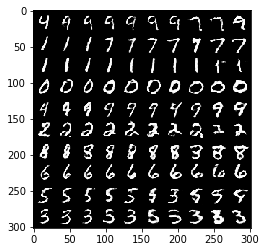

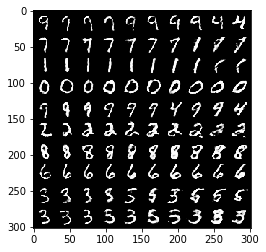

Epoch:3, Iter:400, Dloss: 1.205865502357483, Gloss: 0.924843966960907, Preal: 0.5613364577293396, Pfake: 0.3900822103023529


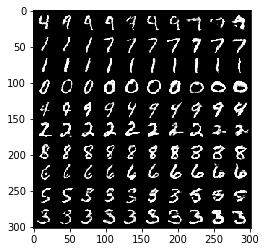

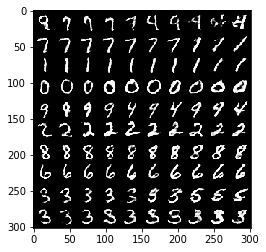

Epoch:4, Iter:0, Dloss: 1.2443716526031494, Gloss: 0.9555308818817139, Preal: 0.5453722476959229, Pfake: 0.40863826870918274


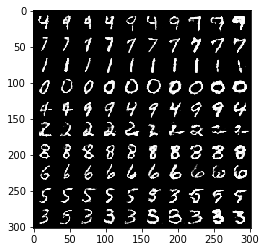

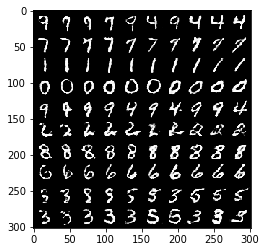

Epoch:4, Iter:200, Dloss: 1.2331490516662598, Gloss: 0.8960974216461182, Preal: 0.5708650946617126, Pfake: 0.40801993012428284


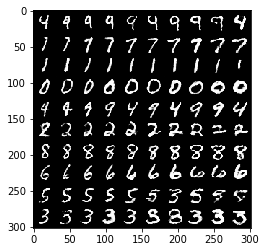

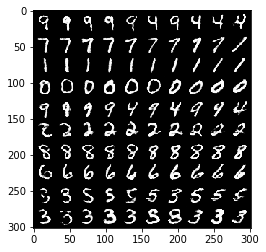

Epoch:4, Iter:400, Dloss: 1.2395446300506592, Gloss: 1.0356045961380005, Preal: 0.5533055663108826, Pfake: 0.4076610207557678


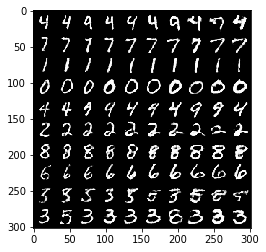

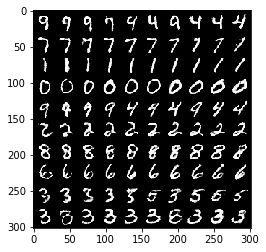

Epoch:5, Iter:0, Dloss: 1.2152161598205566, Gloss: 0.9135177731513977, Preal: 0.555756688117981, Pfake: 0.3968786299228668


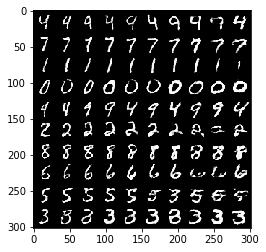

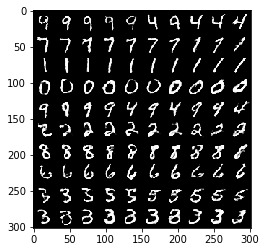

Epoch:5, Iter:200, Dloss: 1.1769721508026123, Gloss: 0.8886663913726807, Preal: 0.564241349697113, Pfake: 0.3960983157157898


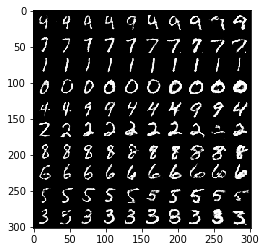

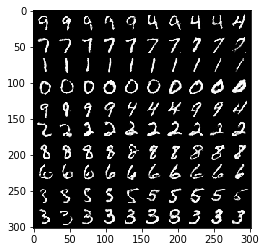

Epoch:5, Iter:400, Dloss: 1.2733690738677979, Gloss: 0.8475838899612427, Preal: 0.5398391485214233, Pfake: 0.4024808704853058


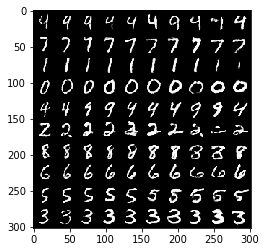

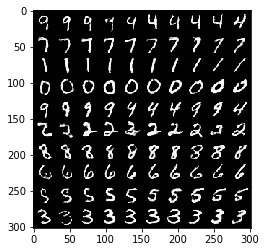

In [ ]:
for epoch in range(8):
    for num_iters, batch_data in enumerate(dataloader,0):
        real_labels = torch.ones(batch_size,1).cuda()
        fake_labels = torch.zeros(batch_size,1).cuda()
        
        # Train Discriminator D and Feature Extractor FE
        # real part
        x, _ = batch_data
        real_x = x.cuda()

        fe_out1 = FE(real_x)
        probs_real = D(fe_out1)
        loss_real = criterionD(probs_real, real_labels)

        # fake part
        dis_c = torch.FloatTensor(batch_size,10).cuda()
        con_c = torch.FloatTensor(batch_size,2).cuda()
        noise = torch.FloatTensor(batch_size,62).cuda()
        z, idx = _noise_sample(dis_c,con_c,noise,batch_size)

        fake_x = G(z)
        fe_out2 = FE(fake_x.detach())
        probs_fake = D(fe_out2)
        loss_fake = criterionD(probs_fake, fake_labels)

        D_loss = loss_real + loss_fake
        
        optimD.zero_grad()
        D_loss.backward()
        optimD.step()

        # Train Generator G and Clasifier Q (Lower bound of InfoMax Term)        
        fe_out = FE(fake_x)
        probs_fake = D(fe_out)
        G_loss = criterionD(probs_fake, real_labels)

        q_logits, q_mu, q_var = Q(fe_out)
        target_class = torch.LongTensor(idx).cuda()
        
        dis_loss = criterionQ_dis(q_logits, target_class)        
        con_loss = criterionQ_con(con_c, q_mu, q_var)*0.1
        
        G_loss_with_InfoMax = G_loss + dis_loss + con_loss
        
        optimG.zero_grad()
        G_loss_with_InfoMax.backward()
        optimG.step()

        if num_iters % 200 == 0:
            print('Epoch:{0}, Iter:{1}, Dloss: {2}, Gloss: {3}, Preal: {4}, Pfake: {5}'.format(
                epoch, num_iters, D_loss.data.cpu().numpy(),
                G_loss_with_InfoMax.data.cpu().numpy(), probs_real.data.mean(), probs_fake.data.mean())
            )

            z = torch.cat([fix_noise, one_hot, c1], 1).view(-1, 74, 1, 1)
            x_save = G(z)
            
            if not os.path.exists('infoGan_out/'):
                os.makedirs('infoGan_out/')
            
            title1 = '(C1)'+str(epoch)+'_'+str(num_iters)
            save_image(x_save.data, 'infoGan_out/'+title1+'.png', nrow=10)
#             vf.imshow_multi(x_save.data.cpu(), nrow=10, title=title1,factor=1)
             
            plt.imshow(make_grid((x_save.data.cpu()), nrow=10).cpu().permute(1,2,0).numpy())
            plt.show()              
            
            z = torch.cat([fix_noise, one_hot, c2], 1).view(-1, 74, 1, 1)
            x_save = G(z)
            
            title2 = '(C2)'+str(epoch)+'_'+str(num_iters)
            save_image(x_save.data, 'infoGan_out/'+title2+'.png', nrow=10)
#             vf.imshow_multi(x_save.data.cpu(), nrow=10, title=title2,factor=1)
            
            plt.imshow(make_grid((x_save.data.cpu()), nrow=10).cpu().permute(1,2,0).numpy())
            plt.show()  
    